In [3]:
import pandas as pd
import numpy as np
import os

from tqdm import tqdm

import nibabel as nib

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image


import sys
import torch
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor
# from models import *


sys.path.insert(0,'/home/roshansk/Covid/CXRData/')
from SegLearner import *

import segmentation_models_pytorch as smp

In [4]:
trainFolder = '/home/roshansk/Covid/Live/ircad-dataset/train/'


In [5]:
dataFiles = os.listdir(trainFolder)

imgFiles = [x for x in dataFiles if 'orig' in x]


In [4]:
dataFiles[1]

'ircad_e01_liver.nii.gz'

In [29]:
img = nib.load(os.path.join(trainFolder, dataFiles[1])).get_data()

In [30]:
img.shape

(512, 512, 129)

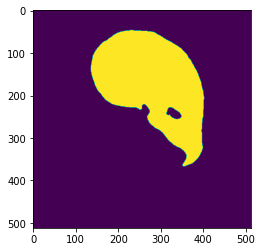

In [32]:
plt.imshow(img[:,:,88])

In [ ]:
data = []
heights = []

for filename in tqdm(trainFileList):
    if 'seg' in filename:
        
        img = nib.load(os.path.join(trainFolder,filename)).get_data()
        heights.append(img.shape[2])
        
        for i in range(img.shape[2]):
            imgSlice = img[:,:,i]
            data.append([filename, i, np.sum(imgSlice)])


sliceDf = pd.DataFrame(data)
sliceDf.columns = ['file','depth','numPixels']

sliceDf.to_csv('sliceData.csv',index = False, index_label = False)

### Creating Slices


In [6]:
sliceFolder = '/home/roshansk/Covid/Live/ircad-dataset/Slices/'

dataFolder = trainFolder

In [5]:
def generateSlices(imgFile, sliceFolder, threshold = 10):

    labelFile = imgFile.replace('orig','liver')

    img = nib.load(os.path.join(dataFolder,imgFile)).get_data()
    label = nib.load(os.path.join(dataFolder,labelFile)).get_data()

    height = img.shape[2]

    for i in range(height):
        labelSum = np.sum(label[:,:,i])

        if labelSum > threshold:
            imgOutFile = '_'.join( [imgFile.split(".")[0],'z',str(i),'image'] )+'.jpg'
            labelOutFile = '_'.join( [imgFile.split(".")[0],'z',str(i),'label'] )+'.jpg'


            imgSlice = img[:,:,i]
            labelSlice = label[:,:,i]
            labelSlice[labelSlice>0] = 1
            
            Image.fromarray(imgSlice).convert('RGB').save(os.path.join(sliceFolder, imgOutFile))
            Image.fromarray(labelSlice).convert('RGB').save(os.path.join(sliceFolder, labelOutFile))

#             marshal.dump(imgSlice.tolist(), open(os.path.join(sliceFolder, imgOutFile), 'wb'))
#             marshal.dump(labelSlice.tolist(), open(os.path.join(sliceFolder, labelOutFile), 'wb'))



In [8]:
for i in tqdm(range(20)):
    imgFile = imgFiles[i]
    
    generateSlices(imgFile, sliceFolder)

100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


In [7]:
sliceList = sorted(os.listdir(sliceFolder))

In [8]:
imgFiles = [x for x in sliceList if 'image' in x]
labelFiles = [x.replace('image','label') for x in imgFiles]

df = pd.DataFrame({'imgPath':imgFiles,'maskPath':labelFiles})
df.imgPath = df.imgPath.apply(lambda x : os.path.join(sliceFolder, x))
df.maskPath = df.maskPath.apply(lambda x : os.path.join(sliceFolder, x))

In [37]:
a = next(iter(trainLoader))

In [38]:
a[0].shape

torch.Size([5, 3, 256, 256])

In [39]:
a[1].shape

torch.Size([5, 256, 256])

In [40]:
mask = a[1][0,:,:]

In [41]:
mask

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [42]:
torch.max(mask)

tensor(1.)

In [1]:
!pip install python

ModuleNotFoundError: No module named 'cv2'

In [57]:
sys.path.insert(0,'/home/roshansk/Covid/RibFrac/Models/')
from models import *

### Modeling

In [20]:
device = 'cuda:1'

batchSize = 5
imgSize = 256


model = smp.Unet('resnet34', encoder_weights='imagenet')

# model = ResNetDUC(num_classes=1)

# model = smp.PSPNet('resnet34', encoder_weights='imagenet')

loss = smp.utils.losses.DiceLoss()

criterion = torch.nn.BCELoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00001),
])

model.to(device)


imgSize=256
trainTransforms = transforms.Compose([transforms.Resize((imgSize,imgSize)), 
                                      ToTensor()])


# trainTransforms = transforms.Compose([transforms.RandomResizedCrop(size = 256,scale = (0.06,0.5), ratio=(0.75, 1.3)), 
#                                       ToTensor()])

classLoss = nn.CrossEntropyLoss()
reconLoss = nn.MSELoss()

# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)


trainDataset = SegDataset(df.iloc[0:1500], trainTransforms)
testDataset = SegDataset(df.iloc[1500:len(df)], trainTransforms)

trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, 
                                          shuffle=True, num_workers=1)


testLoader = torch.utils.data.DataLoader(testDataset, batch_size=batchSize, 
                                          shuffle=False, num_workers=1)

In [10]:
w = next(iter(trainLoader))

In [11]:
w[0].shape

torch.Size([5, 3, 256, 256])

In [13]:
w[1].dtype

torch.float32

In [18]:
pd.Series(w[0].view(-1).cpu().numpy()).value_counts()

0.000000    589683
0.003922     44946
0.007843     27537
0.011765     14127
0.015686      8877
             ...  
0.862745       138
0.780392       135
0.800000       129
0.827451       129
1.000000       126
Length: 256, dtype: int64

In [19]:
pd.Series(w[1].view(-1).cpu().numpy()).value_counts()

0.0    301436
1.0     26244
dtype: int64

In [21]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(trainLoader)
    valid_logs = valid_epoch.run(testLoader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
#     if i == 25:
#         optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 115/115 [00:06<00:00, 16.77it/s, dice_loss - -24.15, iou_score - -0.8341]

Epoch: 1
valid: 100%|██████████| 115/115 [00:07<00:00, 16.39it/s, dice_loss - 9.278, iou_score - -0.6968] 

Epoch: 2
valid: 100%|██████████| 115/115 [00:07<00:00, 16.34it/s, dice_loss - 35.28, iou_score - -5.548]  

Epoch: 3
valid: 100%|██████████| 115/115 [00:06<00:00, 16.73it/s, dice_loss - -116.3, iou_score - -0.3179] 

Epoch: 4
valid: 100%|██████████| 115/115 [00:06<00:00, 16.55it/s, dice_loss - -11.62, iou_score - -0.7945]

Epoch: 5
valid: 100%|██████████| 115/115 [00:07<00:00, 16.27it/s, dice_loss - 48.03, iou_score - -0.6888]  

Epoch: 6
train:  24%|██▍       | 73/300 [00:09<00:32,  6.95it/s, dice_loss - 19.18, iou_score - -6.956]  

In [34]:
sample = next(iter(trainLoader))

In [35]:
img,label = sample

In [36]:
pred = model(img.to(device))

In [37]:
pred.shape

torch.Size([5, 1, 256, 256])

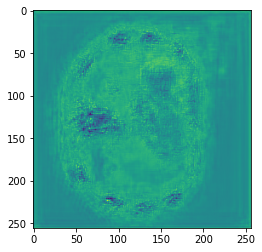

In [40]:
plt.imshow(pred[0,0,:,:].detach().cpu().numpy())

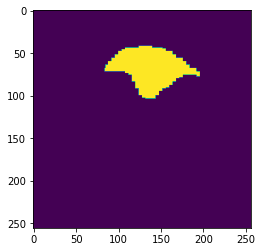

In [44]:
plt.imshow(label[4,:,:])

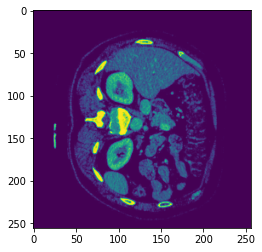

In [45]:
plt.imshow(img[4,0,:,:])

In [59]:
learner = SegLearner(model, trainLoader, optimizer, criterion, testLoader, device = 'cuda:1')

In [60]:
learner.fit(num_epochs=1, save_best_model=False, save_every_epoch=False)

100%|██████████| 115/115 [00:52<00:00,  2.18it/s]


In [51]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [52]:
pred = model(img.to(device))

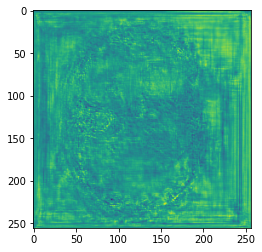

In [56]:
plt.imshow(pred.detach().cpu().numpy()[0,0,:,:])